# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Нам будет необходимо:
* Подготовить данные: привести данные к нужным типам, найти и исправить ошибки.
* Проанализировать данные: описать поведение клиентов оператора, исходя из выборки.
* Проверить гипотезы о выручке пользователей разных тарифов, а также разных регионов.
* Сделать общий вывод о том, какой тариф выгоднее продвигать для компании.

<a id='content'></a>
## Оглавление

### Открытие и предобработка данных 
* [Загрузка датасета и проверка его на наличие дубликатов, пропусков и соответствие типам данных, а также правильность выгрузки](#start)

### Анализ данных
* [Оценка среднего пользователя тарифа Смарт](#part_1.1)
* [Оценка среднего пользователя тарифа Ультра](#part_1.2)
* [Сравнение тарифов Смарт и Ультра](#part_1.3)
* [Вывод](#part_1.4)

### Проверка гипотез
* [Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются](#part_2.1)
* [Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.](#part_2.2)
* [Вывод](#part_2.3)

### Вывод
* [Сделаем общий вывод](#finish)


## Открытие и предобработка данных 
<a id='start'></a>
Загрузка датасетов и проверка их на пропусков и соответствие типам данных, а также правильность выгрузки.
Предобработка данных.

[*Назад к оглавлению*](#content)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data_calls = pd.read_csv('calls.csv')
data_internet = pd.read_csv('internet.csv')
data_messages = pd.read_csv('messages.csv')
data_tariffs = pd.read_csv('tariffs.csv')
data_users = pd.read_csv('users.csv')

In [4]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
data_tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
                        'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Необходимо объединить все данные, которые могут нам понадобиться для дальнейших расчетов, в общую таблицу.

Также необходимо перевести данные из столбцов *call_date*, *session_date*, *message_date*, *reg_date*, *churn_date* в формат даты для более удобного взаимодействия.

Приведем все столбцы с датами к формату даты для облегчения работы с ними.

In [10]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')

Проверим данные на наличие ошибок. Начнем с информации о пользовании интернетом. Проверим, возможно есть нулевые или отрицательные значения потраченых мб.

In [11]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [12]:
data_internet['mb_used'].min()

0.0

Действительно, можем видеть, что у нас есть сессии с нулевым значением потреченых мб. Возможно, выход в интернет по какимто причинам неудался. Удалим данную информацию.

In [13]:
data_internet = data_internet.query('mb_used != 0')
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    129798 non-null  int64         
 1   id            129798 non-null  object        
 2   mb_used       129798 non-null  float64       
 3   session_date  129798 non-null  datetime64[ns]
 4   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.9+ MB


Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя

In [14]:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month
data_calls['calls_rounded'] = np.ceil(data_calls['duration'])
data_calls_pivot = data_calls.pivot_table(index=['user_id'], columns=['month'], values=['calls_rounded'], aggfunc=['count','sum'])

columns_calls =[]

for i in range(1,13):
    columns_calls.append(('calls_count', i))

for i in range(1,13):
    columns_calls.append(('calls_sum', i))

data_calls_pivot.columns = columns_calls

data_calls_pivot.head()

,"(calls_count, 1)","(calls_count, 2)","(calls_count, 3)","(calls_count, 4)","(calls_count, 5)","(calls_count, 6)","(calls_count, 7)","(calls_count, 8)","(calls_count, 9)","(calls_count, 10)",...,"(calls_sum, 3)","(calls_sum, 4)","(calls_sum, 5)","(calls_sum, 6)","(calls_sum, 7)","(calls_sum, 8)","(calls_sum, 9)","(calls_sum, 10)","(calls_sum, 11)","(calls_sum, 12)"
user_id,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,...,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,...,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,...,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,...,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0


In [15]:
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month
data_messages_pivot = data_messages.pivot_table(index=['user_id'], columns=['month'], values=['id'], aggfunc='count')

columns_messages =[]

for i in range(1,13):
    columns_messages.append(('messages', i))

data_messages_pivot.columns = columns_messages

data_messages_pivot.head()

,"(messages, 1)","(messages, 2)","(messages, 3)","(messages, 4)","(messages, 5)","(messages, 6)","(messages, 7)","(messages, 8)","(messages, 9)","(messages, 10)","(messages, 11)","(messages, 12)"
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0


In [16]:
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month
data_internet_pivot = data_internet.pivot_table(index=['user_id'], columns=['month'], values=['mb_used'], aggfunc='sum')

columns_internet =[]

for i in range(1,13):
    columns_internet.append(('mb', i))

data_internet_pivot.columns = columns_internet

data_internet_pivot.head()

,"(mb, 1)","(mb, 2)","(mb, 3)","(mb, 4)","(mb, 5)","(mb, 6)","(mb, 7)","(mb, 8)","(mb, 9)","(mb, 10)","(mb, 11)","(mb, 12)"
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66
1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53
1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04


Объединим все сводные таблицы в одну.

In [17]:
data_pivot = data_calls_pivot.join((data_messages_pivot,data_internet_pivot) , how='outer')
data_pivot.head()

,"(calls_count, 1)","(calls_count, 2)","(calls_count, 3)","(calls_count, 4)","(calls_count, 5)","(calls_count, 6)","(calls_count, 7)","(calls_count, 8)","(calls_count, 9)","(calls_count, 10)",...,"(mb, 3)","(mb, 4)","(mb, 5)","(mb, 6)","(mb, 7)","(mb, 8)","(mb, 9)","(mb, 10)","(mb, 11)","(mb, 12)"
user_id,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,...,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66
1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,...,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,...,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53
1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,...,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04


In [18]:
data_pivot = data_pivot.merge(data_users, on='user_id', how='outer')

In [19]:
data_pivot = data_pivot.merge(data_tariffs, on='tariff', how='outer')

Заполним пропуски в данных о звонках, сообщениях и интернете на нули.

In [20]:
for i in range(1,13):
    data_pivot[('calls_count', i)] = data_pivot[('calls_count', i)].fillna(0)
    data_pivot[('calls_sum', i)] = data_pivot[('calls_sum', i)].fillna(0)
    data_pivot[('messages', i)] = data_pivot[('messages', i)].fillna(0)
    data_pivot[('mb', i)] = data_pivot[('mb', i)].fillna(0)

Посчитаем, сколько месяцев каждый клиент участвовал в плане. Для тех, кто выбыл из плана считаем разницу между месяцем выхода и месяцем прихода +1, для тех, кто все еще в плане: 12 (число месяцев в году) - месяц поступления + 1.

In [21]:
data_pivot['churn_month'] = pd.DatetimeIndex(data_pivot['churn_date']).month
data_pivot['reg_month'] = pd.DatetimeIndex(data_pivot['reg_date']).month

data_pivot['months_in_tariff'] = data_pivot['churn_month'] - data_pivot['reg_month'] + 1

In [22]:
for i in range(len(data_pivot['months_in_tariff'])):
    if ~(data_pivot.loc[i, 'months_in_tariff'] == data_pivot.loc[i, 'months_in_tariff']): #проверяем, что значение Nan
        data_pivot.loc[i, 'months_in_tariff'] = 12 - data_pivot.loc[i, 'reg_month'] + 1

In [23]:
data_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                500 non-null    int64         
 1   (calls_count, 1)       500 non-null    float64       
 2   (calls_count, 2)       500 non-null    float64       
 3   (calls_count, 3)       500 non-null    float64       
 4   (calls_count, 4)       500 non-null    float64       
 5   (calls_count, 5)       500 non-null    float64       
 6   (calls_count, 6)       500 non-null    float64       
 7   (calls_count, 7)       500 non-null    float64       
 8   (calls_count, 8)       500 non-null    float64       
 9   (calls_count, 9)       500 non-null    float64       
 10  (calls_count, 10)      500 non-null    float64       
 11  (calls_count, 11)      500 non-null    float64       
 12  (calls_count, 12)      500 non-null    float64       
 13  (call

Посчитаем сколько денег за звонки, сообщения и интернет переплатил каждый клиент по месяцам.

In [24]:
for i in range(1,13):
    data_pivot[('overlimit_calls', i)] = ((data_pivot[('calls_sum', i)] - data_pivot['minutes_included'])
                                          * data_pivot['rub_per_minute'])
    data_pivot[('overlimit_message', i)] = ((data_pivot[('messages', i)] - data_pivot['messages_included'])
                                            * data_pivot['rub_per_message'])
    data_pivot[('overlimit_mb', i)] = (np.ceil((data_pivot[('mb', i)] - data_pivot['mb_per_month_included']) / 1024)
                                       * data_pivot['rub_per_gb'])                                  


Сейчас у нс могут получаться отрицательные суммы  - если клиент уложился в отведенный лимит. Обнулим эти суммы, ведь за непотраченные минуты, сообщения и мегабайты деньги не возвращаются.

In [25]:
num = data_pivot._get_numeric_data()
num[num < 0] = 0

Посчитаем общую сумму выручки компании по каждому клиенту по месяцам.

In [26]:
for i in range(1,13):
    data_pivot[('proceeds', i)] = (data_pivot[('overlimit_calls', i)] + data_pivot[('overlimit_message', i)] 
                              + data_pivot[('overlimit_mb', i)] 
                              + data_pivot['rub_monthly_fee'])

In [27]:
data_pivot['all_calls_sum'] = data_pivot.apply(lambda _: 0, axis=1) 
data_pivot['messages_sum'] = data_pivot.apply(lambda _: 0, axis=1) 
data_pivot['mb_sum'] = data_pivot.apply(lambda _: 0, axis=1)
data_pivot['proceeds_sum'] = data_pivot.apply(lambda _: 0, axis=1) 
for i in range(1,13):
    data_pivot['all_calls_sum'] += np.ceil(data_pivot[('calls_sum', i)])
    data_pivot['messages_sum'] += data_pivot[('messages', i)]
    data_pivot['mb_sum'] += data_pivot[('mb', i)]
    data_pivot['proceeds_sum'] += data_pivot[('proceeds', i)]
    
data_pivot['calls_average'] = data_pivot['all_calls_sum'] / data_pivot['months_in_tariff']
data_pivot['messages_average'] = data_pivot['messages_sum'] / data_pivot['months_in_tariff']
data_pivot['gb_average'] = np.ceil(data_pivot['mb_sum'] / data_pivot['months_in_tariff'] / 1024)
data_pivot['proceeds_average'] = data_pivot['proceeds_sum'] / data_pivot['months_in_tariff']

Введем категории для города проживания клиента - Москва и прочее.

In [28]:
def fill_city_kind(row):
    if row['city'] == 'Москва':
        return('Москва')
    return('прочее')

data_pivot['city_kind'] = data_pivot.apply(fill_city_kind, axis=1)
data_pivot.head()

,user_id,"(calls_count, 1)","(calls_count, 2)","(calls_count, 3)","(calls_count, 4)","(calls_count, 5)","(calls_count, 6)","(calls_count, 7)","(calls_count, 8)","(calls_count, 9)",...,"(proceeds, 12)",all_calls_sum,messages_sum,mb_sum,proceeds_sum,calls_average,messages_average,gb_average,proceeds_average,city_kind
0,1000,0.0,0.0,0.0,0.0,22.0,43.0,47.0,52.0,58.0,...,-4647.0,2566.0,496.0,107392.31,-59188.0,320.750,62.0,14.0,-7398.500,прочее
1,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,134.0,...,-4173.0,3822.0,380.0,57280.64,-65548.0,764.400,76.0,12.0,-13109.600,Москва
2,1004,0.0,0.0,0.0,0.0,9.0,31.0,22.0,19.0,26.0,...,-3558.0,987.0,1192.0,149039.48,-53921.0,123.375,149.0,19.0,-6740.125,прочее
3,1013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2808.0,936.0,42.0,30517.16,-72972.0,468.000,21.0,15.0,-36486.000,прочее
4,1016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3503.0,122.0,142.0,26810.44,-74286.0,61.000,71.0,14.0,-37143.000,прочее


## Анализ данных
[*Назад к оглавлению*](#content)

Рассмотрим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

Начнем с тарифа Смарт. <a id='part_1.1'></a>

In [29]:
def distplot_options(column, tariff):
    sns.distplot(data_pivot[data_pivot['tariff'] == tariff][column])
    print('Медиана равна', data_pivot[data_pivot['tariff'] == tariff][column].median())
    print('Дисперсия равна', np.var(data_pivot[data_pivot['tariff'] == tariff][column]))
    print('Стандартное отклонение равно', np.std(data_pivot[data_pivot['tariff'] == tariff][column]))

Медиана равна 424.875
Дисперсия равна 21414.557097220324
Стандартное отклонение равно 146.33713505880974


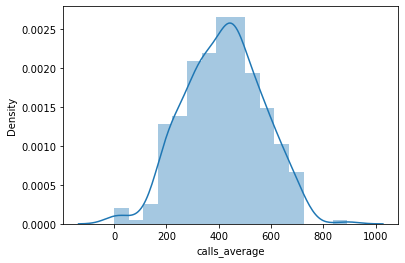

In [30]:
distplot_options('calls_average', 'smart')

Можем заметить, что среднее число минут разговоров в тарифе смарт в месяц составляет 425 минут. То есть большинство клиентов укладываются в лимит в 500 минут. Данную величину хорошо описыват нормальное распределение.

Медиана равна 27.5
Дисперсия равна 701.8781581237815
Стандартное отклонение равно 26.49298318656813


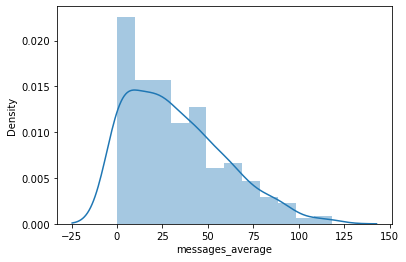

In [31]:
distplot_options('messages_average', 'smart')

Среднее число сообщений составляет 27,5 в месяц. Однако стандартное отклонение практически равно среднему знаячению - 26,5. Также можно заметить, что распределение сильно смещено вправо.

Медиана равна 16.0
Дисперсия равна 12.983125136971246
Стандартное отклонение равно 3.603210393103801


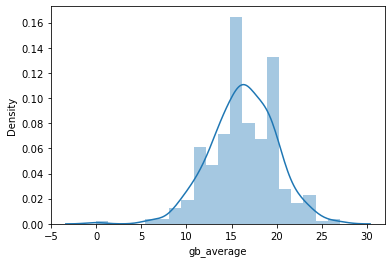

In [32]:
distplot_options('gb_average', 'smart')

В среднем клиенты тарифа смарт используют 16 гб в месяц, что превышает бесплатный лимит в 15 гб. Также можно заметить еще один пик на уровне 19 гб.

Рассмотрим тариф Ультра. <a id='part_1.2'></a>

Медиана равна 513.3333333333334
Дисперсия равна 80194.95452340918
Стандартное отклонение равно 283.18713693141


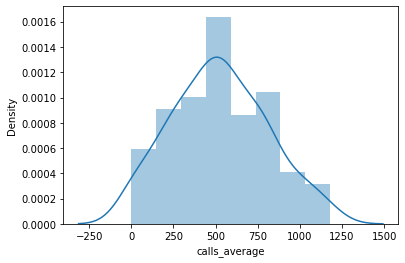

In [33]:
distplot_options('calls_average', 'ultra')

Среднее число минут, которые используют клиенты тарифа Ультра составляет 513 минут - что не сильно отличается от значений в тарифе Смарт. Однако стандартное отклонение существенно больше - 283, вместо 146. Это значит, что большее число клиентов тратит большее число минут на звонки.

Медиана равна 45.0
Дисперсия равна 2140.4332957974884
Стандартное отклонение равно 46.26481704057078


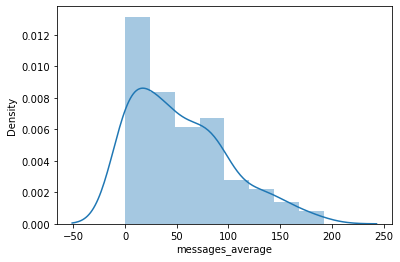

In [34]:
distplot_options('messages_average', 'ultra')

Картина похожа на тариф смарт - распределение также смещено вправо. Однако медиана и стандартное отклонение в два раза больше - все же на тариффе Ультра пишут больше сообщений.

Медиана равна 19.0
Дисперсия равна 67.64343948470788
Стандартное отклонение равно 8.224563178960198


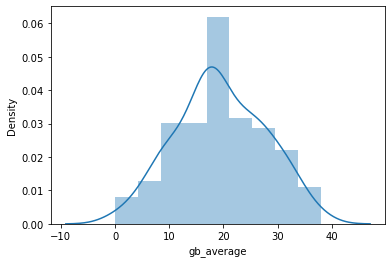

In [35]:
distplot_options('gb_average', 'ultra')

Большинство клиентов тарифа Ультра используют 19 ГБ, что больше, чем в тарифе смарт (16Гб). Также можно наблюдать стандартное отклонение, равное 8, что больше, чем в 2 раза больше, чем в тарифе смарт.

Для наглядности посмотрим на распределения по разным тарифам на одном графике. <a id='part_1.3'></a>

In [36]:
def two_tariffs_options(column):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes[0].hist(data_pivot[data_pivot['tariff'] == 'smart'][column], alpha=0.5)
    axes[0].hist(data_pivot[data_pivot['tariff'] == 'ultra'][column], alpha=0.5)
    fig.legend(labels=['smart','ultra'])
    fig.suptitle(column)
    axes[1].boxplot(data_pivot[data_pivot['tariff'] == 'smart'][column])
    axes[1].boxplot(data_pivot[data_pivot['tariff'] == 'ultra'][column])

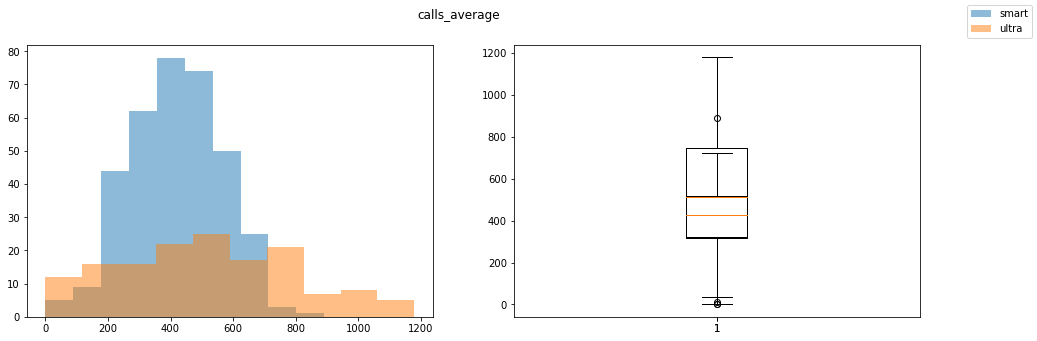

In [37]:
two_tariffs_options('calls_average')

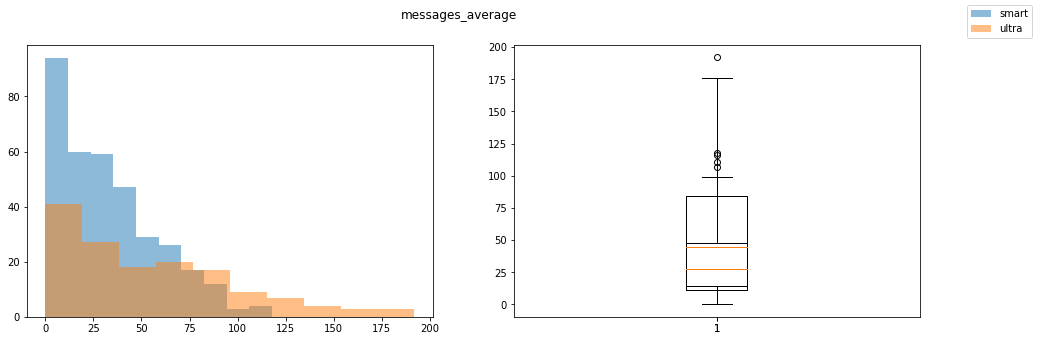

In [38]:
two_tariffs_options('messages_average')

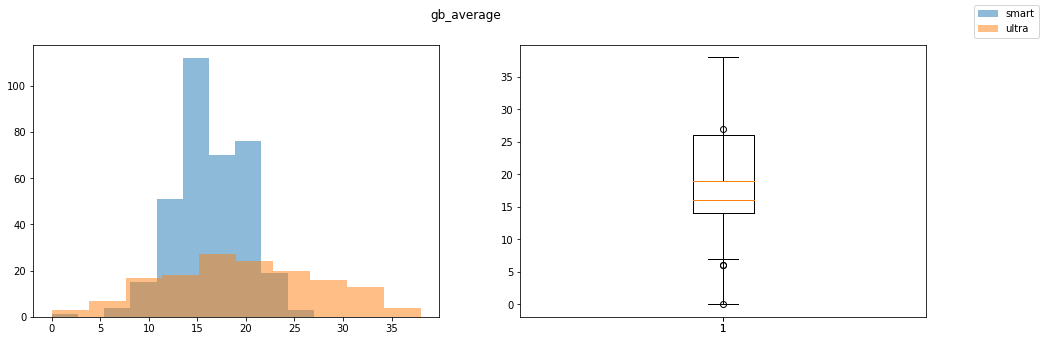

In [39]:
two_tariffs_options('gb_average')

### Вывод <a id='part_1.4'></a>

Среднее количество звонков, сообщений и интернета, используемые клиентами тарифов Смарт и Ультра, хорошо описываются нормальным распределением. В целом ситуации схожи, но на тарифе Ультра, ожидаемо, используется больше.

## Проверка гипотез
[*Назад к оглавлению*](#content)

Нам необходимо проверить следующие гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

<a id='part_2.1'></a>
Начнем с первой. Пойдем от обратного: предположим, что средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова. Таким образом мы можем сформулировать нулевую гипотезу:

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.**

Тогда альтернативная гипотеза будет:

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различна.**

Для начала посмотрим, похожи ли дисперсии выборок.

In [40]:
print('Дисперсия выборки тарифа смарт равна', np.var(data_pivot[data_pivot['tariff'] == 'smart']['proceeds_average']))
print('Дисперсия выборки тарифа ультра равна', np.var(data_pivot[data_pivot['tariff'] == 'ultra']['proceeds_average']))

Дисперсия выборки тарифа смарт равна 148295654.9557878
Дисперсия выборки тарифа ультра равна 297382636.31822133


Очевидно, что в данном случае дисперcии различны.

In [41]:
alpha = 0.05

results = st.ttest_ind(data_pivot[data_pivot['tariff'] == 'smart']['proceeds_average'], 
                       data_pivot[data_pivot['tariff'] == 'ultra']['proceeds_average'],
                       equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2699076357485752e-05
Отвергаем нулевую гипотезу


Видим, что p-значение близко к нулю. Это означает, что мы отвергаем нулевую гипотезу, то есть можем сказать, что средняя выручка пользователей различна.

Построим гистограмы распределений, чтобы посмотреть, действительно ли результаты похожи на действительность.

Медиана равна -3391.0
Дисперсия равна 148295654.9557878
Стандартное отклонение равно 12177.670341891662


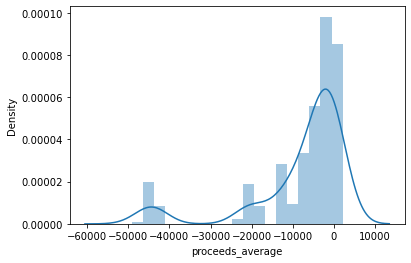

In [42]:
distplot_options('proceeds_average', 'smart')

Медиана равна -7696.166666666667
Дисперсия равна 297382636.31822133
Стандартное отклонение равно 17244.785771885407


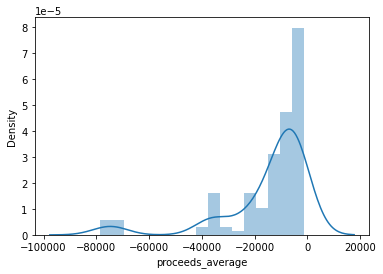

In [43]:
distplot_options('proceeds_average', 'ultra')

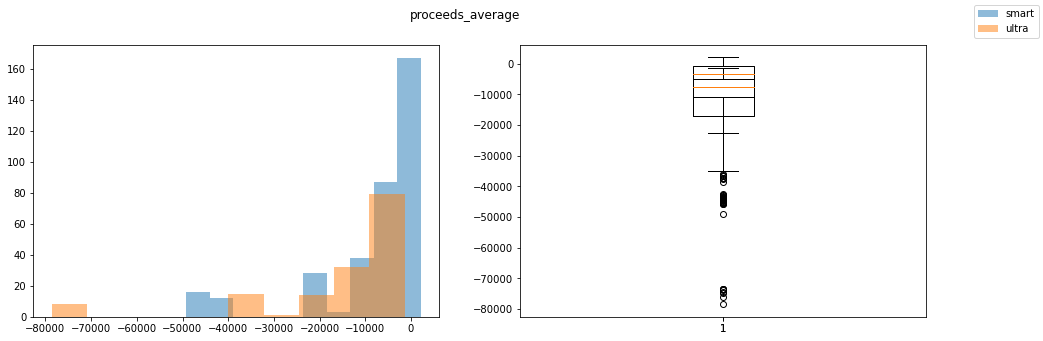

In [44]:
two_tariffs_options('proceeds_average')

Очевидно, что выручка в тарифе Ультра существенно больше (ведь и сам тариф дороже).

<a id='part_2.2'></a>
Рассмотрим вторую гипотезу. Также пойдем от обратного и сформулируем нулевую гипотезу:

**Средняя выручка пользователей из Москвы и других регионов одинакова.**

Тогда альтернативная гипотеза будет:

**Средняя выручка пользователей из Москвы и других регионов различна.**

Для начала посмотрим, похожи ли дисперсии выборок.

In [45]:
print('Дисперсия выборки по Москве равна', np.var(data_pivot[data_pivot['city_kind'] == 'Москва']['proceeds_average']))
print('Дисперсия выборки по регионам равна', np.var(data_pivot[data_pivot['city_kind'] == 'прочее']['proceeds_average']))

Дисперсия выборки по Москве равна 136263082.84174016
Дисперсия выборки по регионам равна 219344227.37763828


Очевидно, что в данном случае диспервии различны.

In [46]:
alpha = 0.05

results = st.ttest_ind(data_pivot[data_pivot['city_kind'] == 'Москва']['proceeds_average'], 
                       data_pivot[data_pivot['city_kind'] == 'прочее']['proceeds_average'],
                       equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9942694503993124
Не получилось отвергнуть нулевую гипотезу


Даже если бы мы взяли большее значение критического уровня статистической значимости (например, 10%), все равно не вышло бы отвергнуть нулевую гипотезу. Это значит, что наша первоначальная гипотеза: *средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов* не прошла проверку, и на самом деле выручка пользователей из Москвы и регионов похожа.

### Вывод <a id='part_2.1'></a>

По результатам проведенной проверке гипотез можно сказать следующее:
* Средняя выручка пользователей тарифов «Ультра» и «Смарт» различна
* Средняя выручка пользователей из Москвы и других регионов одинакова

## Общий вывод
<a id='finish'></a>

[*Назад к оглавлению*](#content)

По результатам анализа данных можно сделать следующие выводы:
* среднее число минут разговоров в тарифе смарт в месяц составляет 425 минут. То есть большинство клиентов укладываются в лимит в 500 минут. Данную величину хорошо описыват нормальное распределение. В то же время среднее число минут, которые используют клиенты тарифа Ультра составляет 513 минут - что не сильно отличается от значений в тарифе Смарт. Однако стандартное отклонение существенно больше - 283, вместо 146. Это значит, что большее число клиентов тратит большее число минут на звонки.
* среднее число сообщений в тарифе смарт составляет 27,5 в месяц. Однако стандартное отклонение практически равно среднему знаячению - 26,5. В тарифе Ультра картина похожа на тариф смарт, днако медиана и стандартное отклонение в два раза больше - все же на тариффе Ультра пишут больше сообщений. Также можно заметить, что оба распределения сильно смещены вправо.
* В среднем клиенты тарифа смарт используют 16-19 гб в месяц, что превышает бесплатный лимит в 15 гб. Большинство клиентов тарифа Ультра используют около 19 ГБ интернета ежемесячно.
* Средняя выручка пользователей тарифов «Ультра» и «Смарт» различна
* Средняя выручка пользователей из Москвы и других регионов одинакова


В общем можно сказать, что компании выгодней продвигать тариф Ультра - средняя выручка с него больше. А вот где это делать - в Москве или иных регионах - значения не имеет.